In [1]:
%load_ext autoreload
%autoreload 2

from config import CFG
import dataset
import engine

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric

import torch

import numpy as np
import os
from sklearn.model_selection import train_test_split

In [2]:
debug = True

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [6]:
if not os.path.exists('model_checkpoints/base_model/'):
    model = AutoModelForSeq2SeqLM.from_pretrained(CFG.model_name)
    model.save_pretrained('model_checkpoints/base_model')
else:
    model = AutoModelForSeq2SeqLM.from_pretrained('model_checkpoints/base_model/')

In [7]:
raw_dataset = load_dataset("europa_eac_tm", language_pair=("pl", "en"))

Using custom data configuration pl2en-0da2ec5e9ea613fc
Reusing dataset europa_eac_tm (/home/bartek/.cache/huggingface/datasets/europa_eac_tm/pl2en-0da2ec5e9ea613fc/0.0.0/955b2501a836c2ea49cfe3e719aec65dcbbc3356bbbe53cf46f08406eb77386a)


In [8]:
X = [i['translation']['pl'] for i in raw_dataset['train']]
y = [i['translation']['en'] for i in raw_dataset['train']]

if debug:
    X = X[: CFG.train_batch_size * 8]
    y = y[: CFG.train_batch_size * 8]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(f'train size: {len(x_train)}, valid size: {len(x_valid)}')

train size: 51, valid size: 13


In [9]:
train_ds = dataset.TranslationDataset(x_train, y_train, tokenizer)

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, CFG.train_batch_size, num_workers = 1)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)

In [12]:
# engine.train_fn(model, optimizer, train_dl, device, scheduler=None)

In [13]:
valid_ds  = dataset.TranslationDataset(x_valid, y_valid, tokenizer)

In [14]:
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=CFG.valid_batch_size,  num_workers = 1)

In [15]:
# valid_loss = engine.valid_fn(model, valid_dl, device)

In [16]:
valid_loss

11.147421836853027

In [17]:
# all_outputs, all_targets = engine.eval_fn(model, valid_dl, device)

In [18]:
len(all_targets)

13

In [19]:
metrics = load_metric('sacrebleu')

In [20]:
metrics

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: The system stream (a sequence of segments).
    references: A list of one or more reference streams (each a sequence of segments).
    smooth_method: The smoothing method to use. (Default: 'exp').
    smooth_value: The smoothing value. Only valid for 'floor' and 'add-k'. (Defaults: floor: 0.1, add-k: 1).
    tokenize: Tokenization method to use for BLEU. If not provided, defaults to 'zh' for Chinese, 'ja-mecab' for
        Japanese and '13a' (mteval) otherwise.
    lowercase: Lowercase the data. If True, enables case-insensitivity. (Default: False).
    force: Insist that your tokenized input is actually detokenized.

Returns:
    'score': BLEU score,
    'counts'

In [21]:
all_outputs = tokenizer.batch_decode(all_outputs, skip_special_tokens=True)
all_targets = tokenizer.batch_decode(all_targets, skip_special_tokens=True)

In [22]:
tmp = [[i] for i in all_targets]

In [23]:
metrics.compute(predictions=all_outputs, references = tmp)

{'score': 34.84728690453997,
 'counts': [73, 42, 30, 21],
 'totals': [126, 113, 100, 92],
 'precisions': [57.93650793650794, 37.16814159292036, 30.0, 22.82608695652174],
 'bp': 1.0,
 'sys_len': 126,
 'ref_len': 124}

In [24]:
from transformers import AdamW, get_cosine_schedule_with_warmup

In [25]:
optimizer = AdamW(model.parameters(), CFG.lr)
total_steps = CFG.epochs * len(x_train) // CFG.train_batch_size
warmup_steps = len(x_train) // CFG.train_batch_size
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps) 

In [26]:
import matplotlib.pyplot as plt

/home/bartek/miniconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


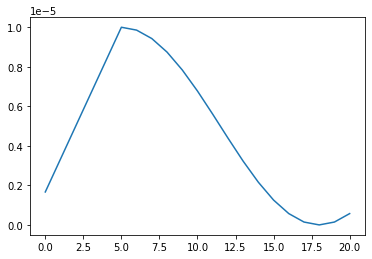

In [27]:
lrs = []
steps = []
i = 0

for epoch in range(CFG.epochs):
    for b in train_dl:
        scheduler.step()
        lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])
        steps.append(i)
        i+=1

plt.plot(steps,lrs)

In [30]:
best_loss_model_checkpoint = 'model_checkpoints/finetuned_model_best_loss'
best_bleu_model_checkpoint = 'model_checkpoints/finetuned_model_best_bleu'

best_loss = float('inf')
best_bleu = 0

for epoch in range(CFG.epochs):
    engine.train_fn(model, optimizer, train_dl, device, scheduler)
    valid_loss = engine.valid_fn(model, valid_dl, device)

    if valid_loss < best_loss:
        best_loss = valid_loss
        model.save_pretrained(best_loss_model_checkpoint)

    all_outputs, all_targets = engine.eval_fn(model, valid_dl, device)

    all_outputs = tokenizer.batch_decode(all_outputs, skip_special_tokens=True)
    all_targets = tokenizer.batch_decode(all_targets, skip_special_tokens=True)
    all_targets = [[i] for i in all_targets]
    score = metrics.compute(predictions=all_outputs, references = tmp)

    if score['score'] < best_bleu:
        best_bleu = score['score']
        model.save_pretrained(best_bleu_model_checkpoint)

    print(f'epoch {epoch + 1}, valid loss: {valid_loss}, bleu score: {score["score"]}')
# engine.train_fn(model, optimizer, train_dl, device, scheduler=None)